### Things tried

**up to 28.06.18:**
- SGD: cannot pass 1.6&ndash;1.7 CV.
- Ridge: cannot pass 1.6&ndash;1.7 CV.
- NN (bottom): cannot pass 1.7&ndash;1.8 CV. More complicated fully-connected NN doesn't help. Convolutions and so on probably not suited to this problem.
- Geometric mean for the lgb folds: good, but no improvement (also 1.43 in LB)
- lgb with the tuned parameters trained on all the data and predicting the full testing set once: not as good as mean of 10 models.
- XGBoost: not as good as LightGBM
- check [this](https://towardsdatascience.com/a-feature-selection-tool-for-machine-learning-in-python-b64dd23710f0) to see a code for feature selection methods
- Removal of constant columns: no improvement, but doesn't hurt.
- Removal of highly correlated columns: no pair of columns are correlated enough in **both** sets (threshold: 0.9).
- Catboost: NOPE.

**29.06.18:**
        
- lgb with tuned parameters and:
    - removing zero variance features (constant columns)
    - log1p features 
    - centering and scaling
    - metric: huber
        - result: 1.384 CV


- lgb with tuned parameters and:
    - removing zero variance features (constant columns)
    - removing highly correlated variables (corr = 0.98)
    - removing zero importance variables
    - log1p features 
    - centering and scaling
    - metric: huber
        - result: 1.374 CV     

- lgb with tuned parameters and:
    - removing zero variance features (constant columns)
    - removing highly correlated variables (corr = 0.98)
    - removing zero importance variables
    - log1p features 
    - centering and scaling
    - metric: rmse
        - result: 1.374 CV
        
- wordbatch: NOPE.
- Revisit XGBoost with removed features: CV 1.424.

**César:** I'm in principle hesitant to remove correlated features in the train data only. Perhaps the differences in the test data could have an impact (I tried a threshold of 0.9 and didn't find ANY correlation in train+test). I think the improvement in CV from 1.385 to 1.375 doesn't come from this, but from removing the zero-importance features.
    **Seba:** Agree.

### Things to try
- [Adversarial validation](http://fastml.com/adversarial-validation-part-two/).
- If we have more than 1 model with good performance we can try a proper stack/blend.
- Check variable importance and [partial dependence](https://www.kaggle.com/dansbecker/partial-dependence-plots) to select features. **César:** I think [shap](https://github.com/slundberg/shap) does a good job!
- Explore ways of optimizing of tuning parameters [read this!](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f)

In [83]:
# misc
import warnings
warnings.filterwarnings('ignore')
import gc

# basic imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
sns.set(palette='colorblind')

# processing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import VarianceThreshold

# models
import lightgbm as lgb
#import xgboost as xgb

#from keras.models import Sequential
#from keras.layers import Dense, Dropout
#from keras.optimizers import SGD

In [3]:
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')

### Visualising the data

In [4]:
train_data.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [5]:
test_data.head()

,ID,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000137c73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00021489f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0004d7953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00056a333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00056d8eb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# remove target and ID columns
target = train_data.target
train_data = train_data.drop(['target', 'ID'], axis=1)
test_ID = test_data.ID
test_data = test_data.drop(['ID'], axis=1)

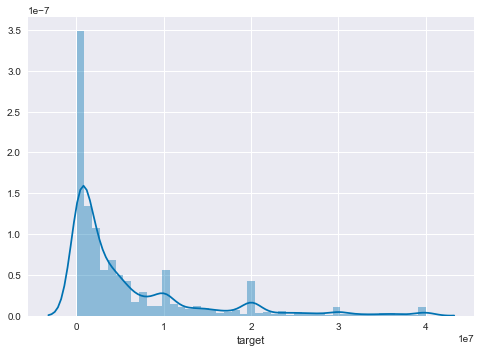

In [7]:
sns.distplot(target)

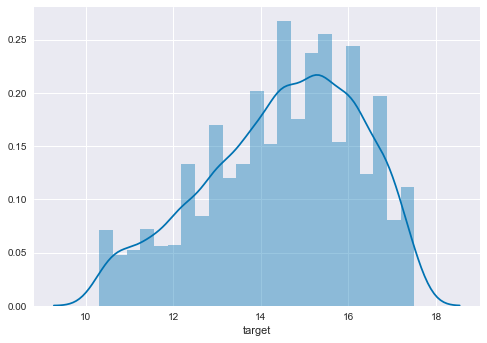

In [8]:
sns.distplot(np.log1p(target))

In [9]:
properties_train = train_data.describe()
properties_test = test_data.describe()

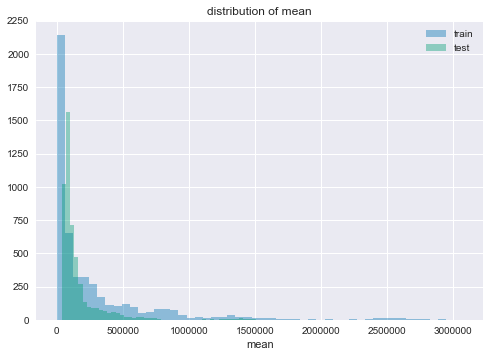

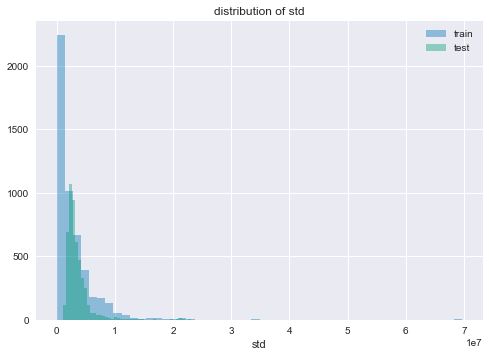

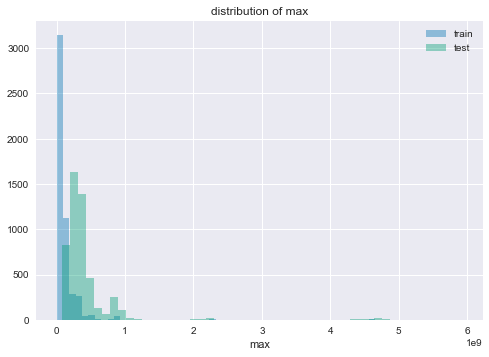

In [10]:
for x in ['mean', 'std', 'max']:
    sns.distplot(properties_train.loc[x], kde=False, label='train')
    sns.distplot(properties_test.loc[x], kde=False, label='test')
    plt.legend()
    plt.title('distribution of '+x)
    plt.show()

### Features in log scale and standarised

In [11]:
from feature_selector import FeatureSelector
fs = FeatureSelector(data=train_data, labels=target)

In [12]:
#identify zero variance features
fs.identify_single_unique()

#identify collinear features
#fs.identify_collinear(correlation_threshold=0.98)
#fs.ops['collinear']

256 features with a single unique value.



Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[75]	valid_0's huber: 4.071e+06
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[94]	valid_0's huber: 4.11785e+06
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[89]	valid_0's huber: 4.29491e+06
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[114]	valid_0's huber: 4.39603e+06
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[93]	valid_0's huber: 4.10748e+06
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[121]	valid_0's huber: 4.19506e+06
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[116]	valid_0's huber: 4.079e+06
Training until validation scores don't impr

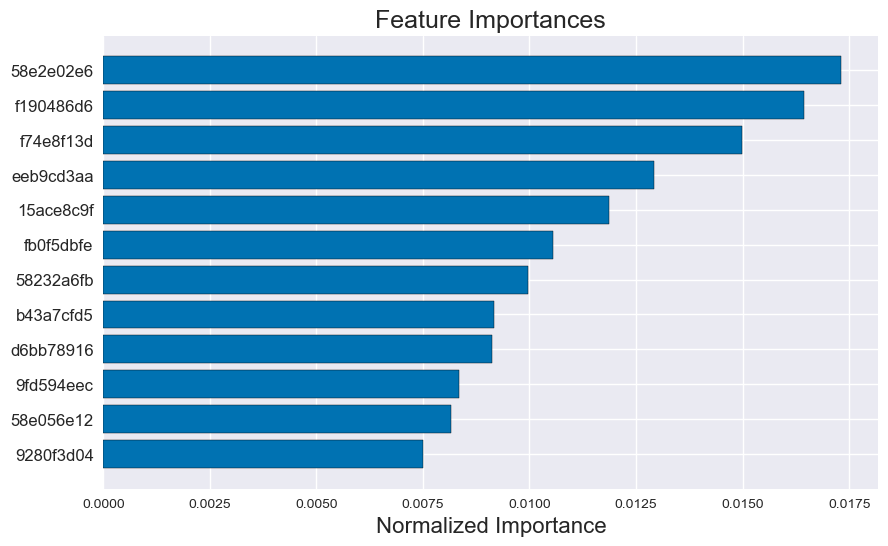

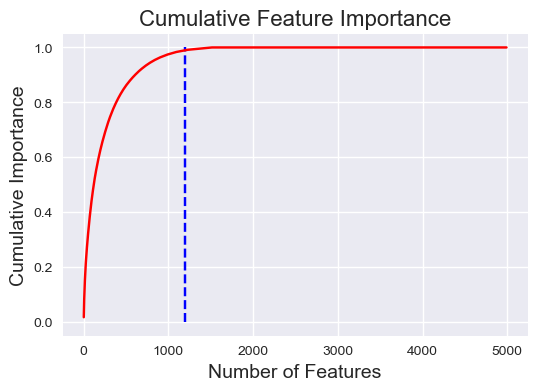

1198 features required for 0.99 of cumulative importance


In [13]:
#zero importance features
fs.identify_zero_importance(task='regression', eval_metric='huber', n_iterations=10, early_stopping=True)

# plot the feature importances
fs.plot_feature_importances(threshold=0.99, plot_n=12)

In [74]:
# Remove the features from all methods
to_remove = fs.check_removal(keep_one_hot=True)
train_data_removed = train_data.drop(to_remove, axis=1)
test_data_removed = test_data.drop(to_remove, axis=1)

Total of 3489 features identified for removal


In [75]:
print('Final number of features: %i' % train_data_removed.shape[1])

Final number of features: 1502


In [66]:
##removing columns with 70% or more proportion of zeros
#prop = np.array([np.sum(train_data_removed.iloc[:,i] == 0.0)/len(train_data_removed.iloc[:,i]) 
#                 for i in range(0,np.shape(train_data_removed)[1])])

#train_data_removed = train_data_removed.loc[:,prop < 0.7]
#test_data_removed = test_data_removed.loc[:,prop < 0.7]

In [76]:
#transform to log
log_features_train = np.log1p(train_data_removed)
log_features_test = np.log1p(test_data_removed)
log_target = np.log1p(target)

In [77]:
#scaling
scaler = StandardScaler()

log_features_train = scaler.fit_transform(log_features_train)
log_features_test = scaler.transform(log_features_test)

In [84]:
# CV folds
kf = KFold(n_splits=10, shuffle=True)
n_splits = kf.get_n_splits()

### lgb

In [85]:
# model parameters
params = {'boosting': 'gbdt', 'objective':'regression', 'num_leaves':150, 'learning_rate':0.01, 'metric':'rmse', 'max_bin':63, 
          'lambda_l2': 0.1, 'device':'cpu', 'feature_fraction': 0.075, 'lambda_l1': 0.007, 'min_data_in_leaf': 5}

In [86]:
submission = pd.DataFrame.from_dict({'ID': test_ID, 'target': np.zeros(test_data.shape[0])})
    
mean_of_errors = 0.

for train_index, test_index in kf.split(log_features_train):

    X_tr, X_tst = log_features_train[train_index], log_features_train[test_index]
    y_tr, y_tst = log_target[train_index], log_target[test_index]

    train_set = lgb.Dataset(X_tr, label=y_tr)
    valid_set = lgb.Dataset(X_tst, label=y_tst, reference=train_set)

    bst = lgb.train(params, train_set, num_boost_round=5000, valid_sets=[train_set, valid_set], early_stopping_rounds=200, verbose_eval=100)

    y_val = bst.predict(X_tst, num_iteration=bst.best_iteration)

    rmsle = np.sqrt(mean_squared_error(y_tst, y_val))

    print('RMSLE: %.5f' % rmsle)

    mean_of_errors += rmsle/n_splits

    submission.target = submission.target + np.expm1(bst.predict(log_features_test, num_iteration=bst.best_iteration))/n_splits

print('\n Fold mean of RMSLE: %.5f' % mean_of_errors)
    
    

Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 1.26053	valid_1's rmse: 1.43826
[200]	training's rmse: 1.0024	valid_1's rmse: 1.34092
[300]	training's rmse: 0.842842	valid_1's rmse: 1.30536
[400]	training's rmse: 0.733375	valid_1's rmse: 1.29249
[500]	training's rmse: 0.653795	valid_1's rmse: 1.28687
[600]	training's rmse: 0.594279	valid_1's rmse: 1.2832
[700]	training's rmse: 0.547381	valid_1's rmse: 1.28148
[800]	training's rmse: 0.509161	valid_1's rmse: 1.27974
[900]	training's rmse: 0.477311	valid_1's rmse: 1.27947
[1000]	training's rmse: 0.449708	valid_1's rmse: 1.27838
[1100]	training's rmse: 0.425688	valid_1's rmse: 1.2775
[1200]	training's rmse: 0.404565	valid_1's rmse: 1.27626
[1300]	training's rmse: 0.386015	valid_1's rmse: 1.27689
[1400]	training's rmse: 0.369142	valid_1's rmse: 1.27729
Early stopping, best iteration is:
[1219]	training's rmse: 0.400918	valid_1's rmse: 1.2761
RMSLE: 1.27610
Training until validation scores don't improve 

In [ ]:
submission.head()

In [ ]:
submission.to_csv('../submission_files/lgb_log_std_10fold_tuned_selected_features_rmse_reg.csv', index=False)

### NN

In [ ]:
submission = pd.DataFrame.from_dict({'ID': test_ID, 'target': np.zeros(test_data.shape[0])})

mean_of_errors = 0.

for train_index, test_index in kf.split(log_features_train):
        
    X_tr, X_tst = log_features_train[train_index], log_features_train[test_index]
    y_tr, y_tst = log_target[train_index], log_target[test_index]
        
    model = Sequential()
    model.add(Dense(2, input_dim=X_tr.shape[1], activation='tanh'))
    model.add(Dense(1))
    
    sgd = SGD(lr=0.05, momentum=0.1)
    model.compile(optimizer=sgd, loss='mse', metrics=['mse'])
    
    model.fit(X_tr, y_tr, validation_data=(X_tst, y_tst), epochs=10)
    
    y_val = model.predict(X_tst)
    
    rmsle = np.sqrt(mean_squared_error(y_tst, y_val))
    
    print('RMSLE: %.5f' % rmsle)
    
    mean_of_errors += rmsle/n_splits
        
    submission.target = submission.target + np.expm1(model.predict(log_features_test)[:,0])/n_splits
    
print('\n Fold mean of RMSLE: %.5f' % mean_of_errors)

In [ ]:
submission.head()

In [ ]:
submission.to_csv('../submission_files/nn_log_std_10fold.csv', index=False)

### xgb

In [36]:
# model parameters

params = {'booster': 'gbtree', 'learning_rate':0.01, 'colsample_bytree': 0.075, 'eval_metric':'rmse', 'lambda': 2.5,
          'alpha': 0.05}

In [29]:
submission = pd.DataFrame.from_dict({'ID': test_ID, 'target': np.zeros(test_data.shape[0])})

mean_of_errors = 0.

test_set = xgb.DMatrix(log_features_test)

for train_index, test_index in kf.split(log_features_train):
        
    X_tr, X_tst = log_features_train[train_index], log_features_train[test_index]
    y_tr, y_tst = log_target[train_index], log_target[test_index]
        
    train_set = xgb.DMatrix(X_tr, label=y_tr)
    valid_set = xgb.DMatrix(X_tst, label=y_tst)
        
    bst = xgb.train(params, train_set, num_boost_round=10000, evals=[(train_set, 'train'), (valid_set, 'val')],
                    early_stopping_rounds=250, verbose_eval=100)
    
    y_val = bst.predict(valid_set, ntree_limit=bst.best_ntree_limit)
    
    rmsle = np.sqrt(mean_squared_error(y_tst, y_val))
    
    print('RMSLE: %.5f' % rmsle)
    
    mean_of_errors += rmsle/n_splits
        
    submission.target = submission.target + np.expm1(bst.predict(test_set, ntree_limit=bst.best_ntree_limit))/n_splits
        
print('\n Fold mean of RMSLE: %.5f' % mean_of_errors)

[0]	train-rmse:13.9542	val-rmse:14.0191
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 250 rounds.
[100]	train-rmse:5.34451	val-rmse:5.4152
[200]	train-rmse:2.3982	val-rmse:2.50345
[300]	train-rmse:1.54827	val-rmse:1.70507
[400]	train-rmse:1.3337	val-rmse:1.53405
[500]	train-rmse:1.26195	val-rmse:1.4941
[600]	train-rmse:1.22277	val-rmse:1.47827
[700]	train-rmse:1.19246	val-rmse:1.46935
[800]	train-rmse:1.16364	val-rmse:1.46287
[900]	train-rmse:1.14055	val-rmse:1.45998
[1000]	train-rmse:1.11797	val-rmse:1.45592
[1100]	train-rmse:1.1002	val-rmse:1.45208
[1200]	train-rmse:1.0823	val-rmse:1.44961
[1300]	train-rmse:1.06725	val-rmse:1.44739
[1400]	train-rmse:1.05271	val-rmse:1.44557
[1500]	train-rmse:1.03737	val-rmse:1.44286
[1600]	train-rmse:1.02501	val-rmse:1.44059
[1700]	train-rmse:1.01247	val-rmse:1.43869
[1800]	train-rmse:1.00117	val-rmse:1.4373
[1900]	train-rmse:0.991369	val-rmse:1.43542
[2000]	train-rms

[900]	train-rmse:1.15196	val-rmse:1.44828
[1000]	train-rmse:1.12895	val-rmse:1.44483
[1100]	train-rmse:1.10997	val-rmse:1.44211
[1200]	train-rmse:1.09167	val-rmse:1.44075
[1300]	train-rmse:1.07603	val-rmse:1.4394
[1400]	train-rmse:1.06092	val-rmse:1.43712
[1500]	train-rmse:1.04649	val-rmse:1.43446
[1600]	train-rmse:1.03442	val-rmse:1.43396
[1700]	train-rmse:1.02204	val-rmse:1.43341
[1800]	train-rmse:1.01036	val-rmse:1.43274
[1900]	train-rmse:0.998218	val-rmse:1.43157
[2000]	train-rmse:0.98804	val-rmse:1.43042
[2100]	train-rmse:0.978273	val-rmse:1.42967
[2200]	train-rmse:0.967821	val-rmse:1.42895
[2300]	train-rmse:0.95882	val-rmse:1.42821
[2400]	train-rmse:0.949229	val-rmse:1.42776
[2500]	train-rmse:0.940219	val-rmse:1.42687
[2600]	train-rmse:0.931617	val-rmse:1.42612
[2700]	train-rmse:0.922178	val-rmse:1.42486
[2800]	train-rmse:0.914322	val-rmse:1.4249
[2900]	train-rmse:0.905728	val-rmse:1.4245
[3000]	train-rmse:0.898473	val-rmse:1.42428
[3100]	train-rmse:0.891371	val-rmse:1.42419
[320

[1400]	train-rmse:1.07189	val-rmse:1.37509
[1500]	train-rmse:1.05701	val-rmse:1.37329
[1600]	train-rmse:1.04411	val-rmse:1.37227
[1700]	train-rmse:1.03204	val-rmse:1.37116
[1800]	train-rmse:1.02058	val-rmse:1.37106
[1900]	train-rmse:1.00954	val-rmse:1.36997
[2000]	train-rmse:0.997477	val-rmse:1.36939
[2100]	train-rmse:0.987115	val-rmse:1.3692
[2200]	train-rmse:0.976672	val-rmse:1.3685
[2300]	train-rmse:0.967697	val-rmse:1.36841
[2400]	train-rmse:0.958426	val-rmse:1.36847
[2500]	train-rmse:0.949589	val-rmse:1.36886
Stopping. Best iteration:
[2285]	train-rmse:0.96916	val-rmse:1.36823

RMSLE: 1.36823

 Fold mean of RMSLE: 1.42381


In [38]:
submission.head()

,ID,target
0,000137c73,1.900761e+06
1,00021489f,1.871472e+06
2,0004d7953,1.286523e+06
3,00056a333,9.247469e+06
4,00056d8eb,1.903365e+06


In [39]:
submission.to_csv('../submission_files/xgb_log_std_10fold.csv', index=False)